In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(ggpubr)
library(fgsea)
library(clusterProfiler)
library(org.Hs.eg.db)
require(dplyr)
require(stringr)

# project directories, and libraries loaded and saving total number of patients

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v3.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

num_pat_tot = length(MM_patients[2,])
num_cell_line_tot = length(MM_cell_line[2,])

# checking total number of patients and cell lines and output head

head(MM_cell_line)
head(MM_patients)
print(num_pat_tot)
print(num_cell_line_tot)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

Sample,GENE_NAME,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,2,0,100,2,0,0,2,88,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,TNMD,1,0,0,0,1,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,DPM1,3949,4134,4795,8278,2262,2587,3607,2450,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,SCYL3,1597,1513,2412,1988,1530,926,1415,573,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,C1orf112,3072,1488,2193,4091,3208,1170,3614,1618,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,FGR,0,22,701,5,2,4,89,4,⋯,0,125,777,50,1890,2315,1514,5,3776,847


GENE_ID,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,⋯,46,14,303,2007,58,77,1037,11,174,22


[1] 893
[1] 68


In [2]:
# finding genes in common and creating character vector of Ensembl Gene IDs

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

# assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

# removing gene ID and gene name columns 
# and saving them in a separate place 
# note only those available in MM_cell_line
# also filtering out genes in common
# and fusing them into a single dataframe
# and filtering for only newly diagnosed patients
# to be kept in a separate data frame

ensembl_ids = MM_cell_line[,1]
MM_cell_line = MM_cell_line[, -1]
gene_names = MM_cell_line[,1]
gene_info = cbind(ensembl_ids, gene_names)

MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[ensembl_intersect, ]
MM_patients = MM_patients[ensembl_intersect, -1]

MM_patient_ids = data.frame(colnames(MM_patients))
MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")
keepc = colnames(MM_patients) %in% MM_patients_new[,1]
MM_patients_nd = MM_patients[,keepc]

MM_combined = cbind(MM_cell_line, MM_patients)
MM_combined_nd = cbind(MM_cell_line, MM_patients_nd)

# checking output head to confirm removal

head(MM_cell_line)
head(MM_patients)
head(MM_combined)
head(MM_combined_nd)
head(gene_info)

# saving number of newly diagnosed patients and printing out percentage

num_new_pat = length(MM_patients_nd[2,])
print(num_new_pat)
print((num_new_pat/num_pat_tot)*100)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,0,125,777,50,1890,2315,1514,5,3776,847


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,MMRF_2341_1_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,43,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,2403,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,1203,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,478,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,555,⋯,46,14,303,2007,58,77,1037,11,174,22


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,46,14,303,2007,58,77,1037,11,174,22


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,3064,46,46,14,303,58,77,11,174,22


ensembl_ids,gene_names
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112
ENSG00000000938,FGR


[1] 779
[1] 87.23404


In [3]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes
# and repeating for newly diagnosed only patients

MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

MM_combined_nd_cpm = cpm(MM_combined_nd)
keep_nd = rowSums(MM_combined_nd_cpm > 1) > 2
MM_combined_nd.filtered = MM_combined_nd[keep_nd, ]
MM_patients_nd = MM_patients_nd[keep_nd, ]
MM_cell_line_nd = MM_cell_line[keep_nd, ]

# checking output head and number of low count genes remaining after filtering

head(keep)
head(MM_combined.filtered)
sum(keep)
sum(keep_nd)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,46,14,303,2007,58,77,1037,11,174,22
ENSG00000000971,11,207,24,21,18,8,685,12,28,2,⋯,13,5,28,118,30,18,1865,1680,56,10


[1] 22677

[1] 22459

In [4]:
# normalizing combined data frames with vst

norm_combined = vst(as.matrix(MM_combined.filtered))
norm_combined_nd = vst(as.matrix(MM_combined_nd.filtered))

# checking output head

head(norm_combined)
head(norm_combined_nd)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000419,11.203503,11.074854,11.494757,11.915436,10.309063,10.999754,11.088513,11.014313,10.141935,11.745230,⋯,11.193842,10.433799,8.751681,12.055311,11.140925,11.779415,10.405654,10.644307,10.820096,10.844967
ENSG00000000457,9.931440,9.668281,10.522303,9.902041,9.765565,9.564948,9.777196,9.002211,9.705423,10.347211,⋯,9.503770,9.740347,8.712015,9.055347,7.830135,9.211329,9.518367,9.494629,9.623449,10.069578
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000419,11.192958,11.058860,11.481792,11.894072,10.306507,10.979705,11.075250,11.003090,10.138017,11.723434,⋯,11.124923,11.843401,11.180281,10.426509,8.784326,11.123679,11.761265,10.632905,10.805345,10.830429
ENSG00000000457,9.936576,9.672406,10.518177,9.901600,9.772317,9.566903,9.781765,9.028327,9.709607,10.338227,⋯,9.384906,8.525344,9.514931,9.744664,8.746203,7.907656,9.229529,9.503027,9.627453,10.065296
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982


In [5]:
# separating out patient and cell line columns from norm_combined and norm_combined_nd

norm_pat = norm_combined[,colnames(MM_patients)]
norm_cell = norm_combined[,colnames(MM_cell_line)]
norm_pat_nd = norm_combined_nd[,colnames(MM_patients_nd)]
norm_cell_nd = norm_combined_nd[,colnames(MM_cell_line_nd)]

# checking output head

head(norm_pat)
head(norm_cell)
head(norm_pat_nd)
head(norm_cell_nd)

,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,MMRF_2341_1_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.763143,9.537185,7.395753,5.308595,9.830803,5.274120,5.550078,5.500219,4.872554,5.880590,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000419,10.974725,11.195989,11.818120,10.507028,11.038501,11.074396,11.418836,10.688833,10.510092,10.569849,⋯,11.193842,10.433799,8.751681,12.055311,11.140925,11.779415,10.405654,10.644307,10.820096,10.844967
ENSG00000000457,8.420720,9.249930,8.461872,10.477123,8.968302,10.433395,9.951931,9.797906,9.553685,9.607254,⋯,9.503770,9.740347,8.712015,9.055347,7.830135,9.211329,9.518367,9.494629,9.623449,10.069578
ENSG00000000460,7.240012,8.035522,6.362907,7.950493,7.004830,8.922297,8.080643,8.263642,9.527754,8.376546,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,8.838641,6.773748,7.792299,7.996890,11.158836,10.511120,5.550078,8.499929,8.827716,8.569701,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,8.954700,9.660588,9.272141,7.626551,8.452307,12.823135,5.732564,8.006766,9.272567,5.736415,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.707500,4.277689,4.277689,4.277689,4.277689,4.277689,4.277689,4.277689,4.628974,6.456153
ENSG00000000419,11.203503,11.074854,11.494757,11.915436,10.309063,10.999754,11.088513,11.014313,10.141935,11.745230,⋯,11.213561,10.093941,11.352302,10.930239,10.590877,11.140197,11.955852,11.043716,12.398838,12.666907
ENSG00000000457,9.931440,9.668281,10.522303,9.902041,9.765565,9.564948,9.777196,9.002211,9.705423,10.347211,⋯,9.264065,9.779521,8.749033,10.037164,9.668741,9.472541,9.649261,8.832004,9.858348,9.669506
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,10.360803,10.367704,10.104580,10.385818,10.599902,9.880745,10.441824,10.134136,8.954919,8.491219
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,4.277689,7.148103,9.347799,6.008208,9.896101,10.192478,9.731689,4.776205,11.116661,8.761160
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,7.084740,5.339650,6.334592,4.643934,6.922797,5.655105,6.618223,8.390881,7.857338,7.031385


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2341_1_BM,MMRF_2501_1_BM,MMRF_1383_1_BM,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,6.060798,9.545865,7.504912,5.678664,9.831334,5.882917,5.839145,6.162487,9.012450,10.080853,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000419,10.957643,11.180638,11.796341,10.495380,11.022594,11.404325,10.675590,10.560857,10.541196,10.548945,⋯,11.124923,11.843401,11.180281,10.426509,8.784326,11.123679,11.761265,10.632905,10.805345,10.830429
ENSG00000000457,8.464263,9.266066,8.504619,10.465857,8.991437,9.954385,9.798282,9.614478,9.901645,9.854608,⋯,9.384906,8.525344,9.514931,9.744664,8.746203,7.907656,9.229529,9.503027,9.627453,10.065296
ENSG00000000460,7.361361,8.102342,6.578214,8.019636,7.149116,8.146953,8.315703,8.425506,7.797638,7.725440,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,8.864747,6.942817,7.872284,8.063233,11.141904,5.882917,8.540640,8.609911,6.225164,6.277881,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,8.976686,9.666459,9.285435,7.717287,8.495919,6.037327,8.073008,6.039664,6.582150,6.067497,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.183315,4.830701,4.830701,4.830701,4.830701,4.830701,4.830701,4.830701,5.118442,6.661173
ENSG00000000419,11.192958,11.058860,11.481792,11.894072,10.306507,10.979705,11.075250,11.003090,10.138017,11.723434,⋯,11.203237,10.090880,11.337907,10.916534,10.580120,11.126976,11.934854,11.032084,12.378849,12.643881
ENSG00000000457,9.936576,9.672406,10.518177,9.901600,9.772317,9.566903,9.781765,9.028327,9.709607,10.338227,⋯,9.284631,9.782236,8.783722,10.035066,9.673136,9.484374,9.654509,8.863879,9.861965,9.674925
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,10.359418,10.360492,10.104075,10.378362,10.589037,9.883744,10.433379,10.133464,8.981951,8.534477
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,4.830701,7.279769,9.363245,6.271504,9.895878,10.190136,9.735164,5.239458,11.103832,8.793222
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,7.226316,5.705353,6.555933,5.130448,7.075538,5.971329,6.803862,8.441138,7.936526,7.174217


In [6]:
# utilizing IQR to get vector of top 5000 and top 10000 genes
# for all and newly diagnosed separately

keepi = apply(norm_pat, 1, IQR)
keepis = sort(keepi, decreasing = TRUE)
keepi5000 = keepi %in% keepis[1:5000]
keepi10000 = keepi %in% keepis[1:10000]

keepi_nd = apply(norm_pat_nd, 1, IQR)
keepis_nd = sort(keepi_nd, decreasing = TRUE)
keepi5000_nd = keepi_nd %in% keepis_nd[1:5000]
keepi10000_nd = keepi_nd %in% keepis_nd[1:10000]

In [7]:
# making function for doing correlation analysis and generating violin plots

makeplots = function(corset, pnames, clnames, titl) {
    
    MM.cor.v = cor(corset, method = "s")

    #clnames = colnames(MM_cell_line)
    tumor_cell_all = data.frame()

    for(patients in pnames){
        cell_line_tumor_cor = MM.cor.v[patients, clnames]
        cell_line_tumor_cor = data.frame(patient = patients, 
                                         sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
        tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
    }

    cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
    cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
    tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

      p <- ggplot(tumor_cell_all, aes(sample, cor))
      print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + ylab('R') +
              xlab("") + labs(title = titl) +
              stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                           fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
            theme(panel.background = element_rect(color = 'white'), 
                  axis.text.x = element_text(angle = 70, hjust = 1, size=8))# + stat_compare_means()
      )
   # return(cell_line_order)
}

In [8]:
# subsetting top 5000 / 10000 genes for all patients,
# newly diagnosed patients subsetted from all patients,
# and newly diagnosed patients normalized separately

norm_combined_5 = norm_combined[keepi5000,]
norm_combined_10 = norm_combined[keepi10000,]

norm_combined_ndo_5 = norm_combined[keepi5000,]
tv = norm_combined_ndo_5[,colnames(norm_cell_nd)]
tv2 = norm_combined_ndo_5[,colnames(norm_pat_nd)]
norm_combined_ndo_5 = cbind(tv, tv2)

norm_combined_ndo_10 = norm_combined[keepi10000,]
tv = norm_combined_ndo_10[,colnames(norm_cell_nd)]
tv2 = norm_combined_ndo_10[,colnames(norm_pat_nd)]
norm_combined_ndo_10 = cbind(tv, tv2)

norm_combined_nd_5 = norm_combined_nd[keepi5000_nd,]
norm_combined_nd_10 = norm_combined_nd[keepi10000_nd,]

# checking output head,and getting number of genes in common amongst top 5000 most variable

head(norm_combined_5)
head(norm_combined_ndo_5)
head(norm_combined_nd_5)
sum(rownames(norm_combined_ndo_5) %in% rownames(norm_combined_nd_5))

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621
ENSG00000001561,11.299764,11.117408,10.699169,9.186855,8.748253,10.206546,11.290563,9.731783,10.226765,9.290325,⋯,12.204722,9.798182,7.611145,10.935838,8.829046,10.531100,10.341254,10.757729,10.380698,10.913626
ENSG00000002586,9.380980,6.053948,7.358972,5.070450,10.986954,4.565888,6.487835,4.791415,11.911219,4.744915,⋯,6.041618,6.413483,7.000104,9.279818,8.572020,14.222973,7.211198,6.001932,6.240530,8.344365


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.645601,6.735236,4.724323,7.872087,7.279442,8.268661,5.786579,4.906192,5.573125,5.539938
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,7.396229,6.755457,8.168128,7.194023,7.405635,6.115524,6.992802,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,11.938327,6.672686,6.266877,5.502307,8.612095,7.314219,7.142771,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,11.685182,6.187998,5.392960,5.023380,6.038515,6.621261,5.826595,11.058560,6.433822,5.876621
ENSG00000001561,11.299764,11.117408,10.699169,9.186855,8.748253,10.206546,11.290563,9.731783,10.226765,9.290325,⋯,9.314724,9.272840,12.204722,9.798182,7.611145,8.829046,10.531100,10.757729,10.380698,10.913626
ENSG00000002586,9.380980,6.053948,7.358972,5.070450,10.986954,4.565888,6.487835,4.791415,11.911219,4.744915,⋯,10.704127,10.891096,6.041618,6.413483,7.000104,8.572020,14.222973,6.001932,6.240530,8.344365


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982
ENSG00000001036,7.150127,10.205189,11.706649,11.119109,11.964247,10.869906,12.264824,11.022433,10.523320,11.761523,⋯,11.366889,11.390647,12.240746,9.971044,9.416014,11.431560,12.629040,10.806432,9.426269,10.866817
ENSG00000001561,11.288489,11.101051,10.692980,9.203449,8.783962,10.196110,11.275689,9.738624,10.221523,9.302731,⋯,9.327332,9.286848,12.185353,9.801319,7.705559,8.856684,10.523423,10.745066,10.371202,10.898409


[1] 4638

In [9]:
# saving correlation tables for all patients, newly diagnosed patients subsetted from all patients,
# and newly diagnosed patients normalized separately, for top 5000 and 10000 most variable genes

MM.cor.keats_5000 = cor(norm_combined_5, method = "s")
MM.cor.keats_5000 = MM.cor.keats_5000[colnames(MM_patients), colnames(MM_cell_line)]

MM.cor.keats_10000 = cor(norm_combined_10, method = "s")
MM.cor.keats_10000 = MM.cor.keats_10000[colnames(MM_patients), colnames(MM_cell_line)]

MM.cor.keats_ndo_5000 = MM.cor.keats_5000[colnames(MM_patients_nd),]
MM.cor.keats_ndo_10000 = MM.cor.keats_10000[colnames(MM_patients_nd),]

MM.cor.keats_nd_5000 = cor(norm_combined_nd_5, method = "s")
MM.cor.keats_nd_5000 = MM.cor.keats_nd_5000[colnames(MM_patients_nd), colnames(MM_cell_line)]

MM.cor.keats_nd_10000 = cor(norm_combined_nd_10, method = "s")
MM.cor.keats_nd_10000 = MM.cor.keats_nd_10000[colnames(MM_patients_nd), colnames(MM_cell_line)]

# checking output head

head(MM.cor.keats_5000)
head(MM.cor.keats_ndo_5000)
head(MM.cor.keats_nd_5000)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
MMRF_2801_1_BM,0.4517749,0.4349749,0.4286582,0.4822847,0.4359017,0.3972648,0.3971391,0.4149805,0.4233515,0.3452179,⋯,0.4516974,0.3766863,0.4153700,0.3859249,0.3398826,0.4064589,0.3891746,0.3850782,0.3819718,0.3817107
MMRF_2718_1_BM,0.4581244,0.4431644,0.4038416,0.4653616,0.3949765,0.3453951,0.3860945,0.4110975,0.4140186,0.3285472,⋯,0.4205938,0.3508619,0.3986400,0.3644461,0.3750175,0.3829601,0.3748100,0.3510870,0.3648719,0.3567384
MMRF_2815_1_BM,0.4868771,0.4787737,0.4393861,0.4982120,0.4016501,0.3848549,0.4512338,0.4185613,0.4220763,0.3497691,⋯,0.4289724,0.3936808,0.4322049,0.3792175,0.4420574,0.4152898,0.4072691,0.3801919,0.4053549,0.4719518
MMRF_1656_1_BM,0.5550829,0.5661903,0.5050889,0.5649782,0.4854856,0.4713307,0.5534437,0.4912024,0.5269389,0.4215398,⋯,0.4850777,0.4525768,0.5089535,0.4544614,0.4610639,0.5070892,0.4952512,0.5039261,0.5325579,0.5265956
MMRF_2461_1_BM,0.4130272,0.4097795,0.3883913,0.4387081,0.3858632,0.3390691,0.3917873,0.3618470,0.3893378,0.2929299,⋯,0.3805764,0.2939174,0.3382522,0.3363116,0.2933794,0.3530543,0.3509824,0.3355592,0.3888328,0.3784962
MMRF_2531_2_PB,0.5867580,0.6231016,0.5915989,0.6099328,0.5379066,0.4859530,0.6272871,0.5618400,0.5438244,0.4738110,⋯,0.5375639,0.5169209,0.5658505,0.5283888,0.5861316,0.5713569,0.5726294,0.5650216,0.5306605,0.6052676


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
MMRF_2801_1_BM,0.4517749,0.4349749,0.4286582,0.4822847,0.4359017,0.3972648,0.3971391,0.4149805,0.4233515,0.3452179,⋯,0.4516974,0.3766863,0.4153700,0.3859249,0.3398826,0.4064589,0.3891746,0.3850782,0.3819718,0.3817107
MMRF_2718_1_BM,0.4581244,0.4431644,0.4038416,0.4653616,0.3949765,0.3453951,0.3860945,0.4110975,0.4140186,0.3285472,⋯,0.4205938,0.3508619,0.3986400,0.3644461,0.3750175,0.3829601,0.3748100,0.3510870,0.3648719,0.3567384
MMRF_2815_1_BM,0.4868771,0.4787737,0.4393861,0.4982120,0.4016501,0.3848549,0.4512338,0.4185613,0.4220763,0.3497691,⋯,0.4289724,0.3936808,0.4322049,0.3792175,0.4420574,0.4152898,0.4072691,0.3801919,0.4053549,0.4719518
MMRF_1656_1_BM,0.5550829,0.5661903,0.5050889,0.5649782,0.4854856,0.4713307,0.5534437,0.4912024,0.5269389,0.4215398,⋯,0.4850777,0.4525768,0.5089535,0.4544614,0.4610639,0.5070892,0.4952512,0.5039261,0.5325579,0.5265956
MMRF_2461_1_BM,0.4130272,0.4097795,0.3883913,0.4387081,0.3858632,0.3390691,0.3917873,0.3618470,0.3893378,0.2929299,⋯,0.3805764,0.2939174,0.3382522,0.3363116,0.2933794,0.3530543,0.3509824,0.3355592,0.3888328,0.3784962
MMRF_2057_1_BM,0.5436614,0.5426516,0.4553192,0.5775062,0.4378019,0.4701851,0.5279019,0.4993482,0.5561542,0.3954045,⋯,0.4337368,0.4444602,0.5102732,0.4800311,0.4464399,0.4933961,0.5162781,0.4757506,0.5225110,0.4737961


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
MMRF_2801_1_BM,0.4836378,0.4686470,0.4673668,0.5159783,0.4629237,0.4362713,0.4432058,0.4562471,0.4641367,0.3809849,⋯,0.4822432,0.4170597,0.4518690,0.4246406,0.3811980,0.4448189,0.4333487,0.4284234,0.4318117,0.4243849
MMRF_2718_1_BM,0.4849495,0.4742135,0.4445732,0.4986851,0.4238263,0.3830669,0.4297896,0.4505229,0.4578769,0.3609131,⋯,0.4499876,0.3868856,0.4312632,0.4052534,0.4083806,0.4212332,0.4175788,0.3938507,0.4134381,0.3975064
MMRF_2815_1_BM,0.5091862,0.5064330,0.4771496,0.5271903,0.4292123,0.4188493,0.4921401,0.4548180,0.4632074,0.3782369,⋯,0.4585764,0.4255826,0.4658892,0.4159600,0.4697735,0.4492242,0.4476904,0.4208229,0.4527162,0.5060379
MMRF_1656_1_BM,0.5877339,0.5993928,0.5491432,0.6033711,0.5202250,0.5126301,0.6000781,0.5334721,0.5721010,0.4599265,⋯,0.5209036,0.4941841,0.5514529,0.4984455,0.4998297,0.5496792,0.5424570,0.5512444,0.5797852,0.5676018
MMRF_2461_1_BM,0.4458148,0.4464983,0.4315844,0.4731300,0.4183847,0.3849694,0.4378271,0.4082587,0.4347655,0.3289497,⋯,0.4180156,0.3369164,0.3819786,0.3803042,0.3383132,0.3959002,0.3969621,0.3828487,0.4399801,0.4236413
MMRF_2057_1_BM,0.5746095,0.5751956,0.4935160,0.6114980,0.4710572,0.5040224,0.5667370,0.5380960,0.5972272,0.4307854,⋯,0.4736886,0.4809370,0.5447272,0.5161323,0.4839423,0.5289913,0.5552722,0.5130774,0.5647444,0.5132685


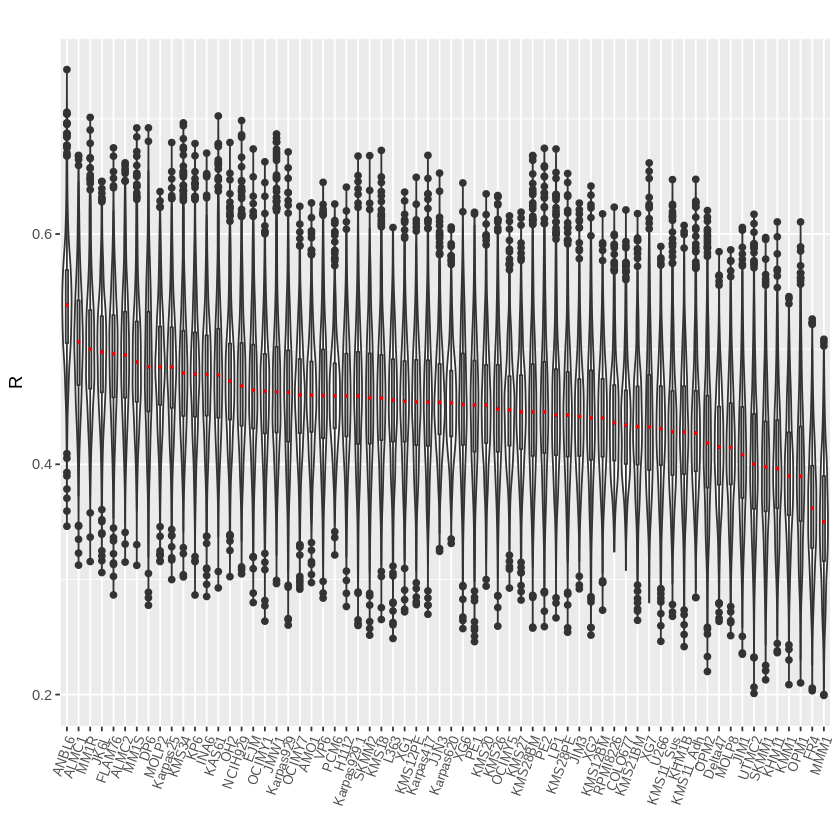

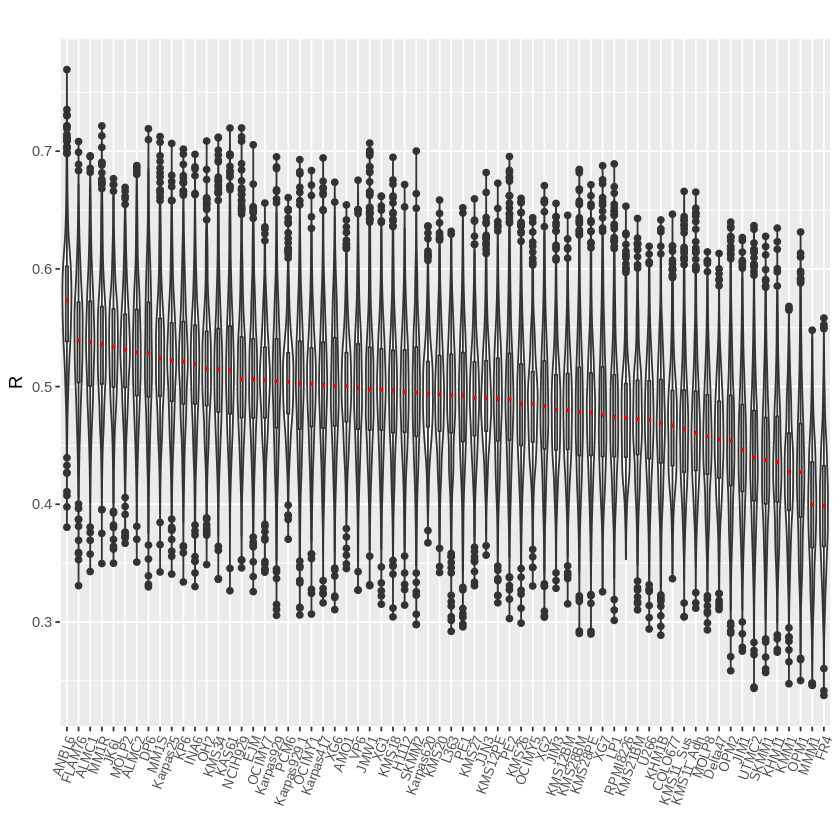

In [10]:
# plots for main analysis using top 5000 / 10000 genes
# for newly diagnosed patients subsetted from all patients, 
# and for newlly diagnosed patients normalized separately

makeplots(norm_combined_ndo_5, colnames(MM_patients_nd), colnames(MM_cell_line), '')
makeplots(norm_combined_nd_5, colnames(MM_patients_nd), colnames(MM_cell_line), '')

,cor,type
,<dbl>,<chr>
ALMC1,0.5066608,Norm. w/ all patients
ALMC2,0.4967268,Norm. w/ all patients
AMO1,0.4595980,Norm. w/ all patients
ANBL6,0.5379676,Norm. w/ all patients
COLO677,0.4367230,Norm. w/ all patients
Delta47,0.4158869,Norm. w/ all patients


,cor,type
,<dbl>,<chr>
ALMC1,0.5369961,Norm. w/ only newly diagnosed patients
ALMC2,0.5300274,Norm. w/ only newly diagnosed patients
AMO1,0.5001054,Norm. w/ only newly diagnosed patients
ANBL6,0.5717817,Norm. w/ only newly diagnosed patients
COLO677,0.4689277,Norm. w/ only newly diagnosed patients
Delta47,0.4551389,Norm. w/ only newly diagnosed patients


,cor,type
,<dbl>,<chr>
ALMC1,0.5066608,Norm. w/ all patients
ALMC2,0.4967268,Norm. w/ all patients
AMO1,0.4595980,Norm. w/ all patients
ANBL6,0.5379676,Norm. w/ all patients
COLO677,0.4367230,Norm. w/ all patients
Delta47,0.4158869,Norm. w/ all patients


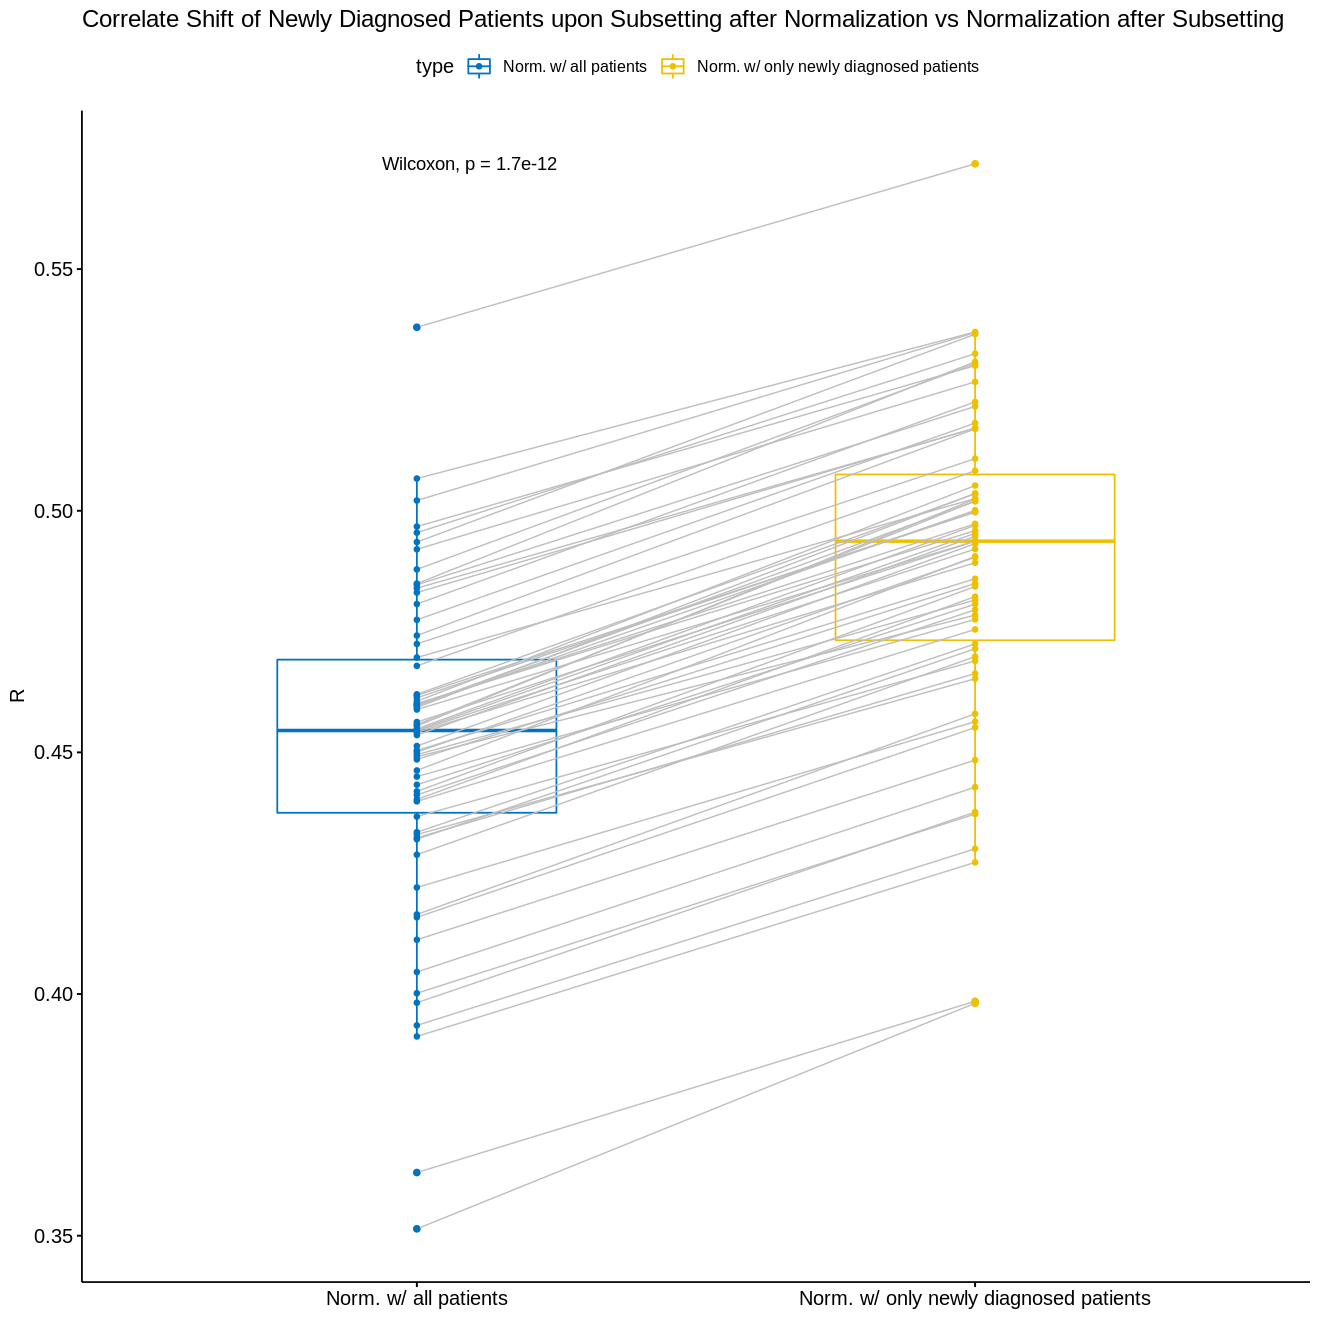

In [11]:
# getting mean correlates of all newly diagnosed patients 
# normalized w/ all patients, and normalized separately
# and labelling them for figures

MM.cor.keats_ndo_5000_means = data.frame(colMeans(MM.cor.keats_ndo_5000))
MM.cor.keats_ndo_5000_means$type = 'Norm. w/ all patients'
colnames(MM.cor.keats_ndo_5000_means) = c('cor', 'type')

MM.cor.keats_nd_5000_means = data.frame(colMeans(MM.cor.keats_nd_5000))
MM.cor.keats_nd_5000_means$type = 'Norm. w/ only newly diagnosed patients'
colnames(MM.cor.keats_nd_5000_means) = c('cor', 'type')

# checking output head

head(MM.cor.keats_ndo_5000_means)
head(MM.cor.keats_nd_5000_means)

# fusing by rows of mean correlates for correlate shift boxplots

normchk_bound = rbind(MM.cor.keats_ndo_5000_means, MM.cor.keats_nd_5000_means)

# checking output head

head(normchk_bound)

# paired boxplot of patient correlates 

options(repr.plot.width = 11, repr.plot.height = 11)

ggpaired(normchk_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco", 
         title = 'Correlate Shift of Newly Diagnosed Patients upon Subsetting after Normalization vs Normalization after Subsetting', 
         ylab = 'R', xlab = FALSE)+
  stat_compare_means(paired = TRUE)

options(repr.plot.width = 7, repr.plot.height = 7)

,cor,type,rank
,<dbl>,<chr>,<int>
ANBL6,0.5379676,Norm. w/ all patients,1
ALMC1,0.5066608,Norm. w/ all patients,2
MM1R,0.5021266,Norm. w/ all patients,3
ALMC2,0.4967268,Norm. w/ all patients,4
JK6L,0.4954662,Norm. w/ all patients,5
FLAM76,0.4935216,Norm. w/ all patients,6


,cor,type,rank
,<dbl>,<chr>,<int>
ANBL6,0.5717817,Norm. w/ only newly diagnosed patients,1
ALMC1,0.5369961,Norm. w/ only newly diagnosed patients,2
MM1R,0.5368689,Norm. w/ only newly diagnosed patients,3
FLAM76,0.5365279,Norm. w/ only newly diagnosed patients,4
JK6L,0.5325068,Norm. w/ only newly diagnosed patients,5
MOLP2,0.5308248,Norm. w/ only newly diagnosed patients,6


,cor,type,rank
,<dbl>,<chr>,<int>
ALMC1,0.5066608,Norm. w/ all patients,2
ALMC2,0.4967268,Norm. w/ all patients,4
AMO1,0.4595980,Norm. w/ all patients,26
ANBL6,0.5379676,Norm. w/ all patients,1
COLO677,0.4367230,Norm. w/ all patients,50
Delta47,0.4158869,Norm. w/ all patients,58


,cor,type,rank
,<dbl>,<chr>,<int>
ALMC1,0.5369961,Norm. w/ only newly diagnosed patients,2
ALMC2,0.5300274,Norm. w/ only newly diagnosed patients,8
AMO1,0.5001054,Norm. w/ only newly diagnosed patients,25
ANBL6,0.5717817,Norm. w/ only newly diagnosed patients,1
COLO677,0.4689277,Norm. w/ only newly diagnosed patients,53
Delta47,0.4551389,Norm. w/ only newly diagnosed patients,58


,cor,type,rank,cor,type,rank
,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>
ALMC1,0.5369961,Norm. w/ only newly diagnosed patients,2,0.5066608,Norm. w/ all patients,2
ALMC2,0.5300274,Norm. w/ only newly diagnosed patients,8,0.4967268,Norm. w/ all patients,4
AMO1,0.5001054,Norm. w/ only newly diagnosed patients,25,0.4595980,Norm. w/ all patients,26
ANBL6,0.5717817,Norm. w/ only newly diagnosed patients,1,0.5379676,Norm. w/ all patients,1
COLO677,0.4689277,Norm. w/ only newly diagnosed patients,53,0.4367230,Norm. w/ all patients,50
Delta47,0.4551389,Norm. w/ only newly diagnosed patients,58,0.4158869,Norm. w/ all patients,58


,Norm. w/ Newly Diagnosed Only,Norm. w/ All Patients
,<int>,<int>
ANBL6,1,1
ALMC1,2,2
MM1R,3,3
FLAM76,4,6
JK6L,5,5
MOLP2,6,9


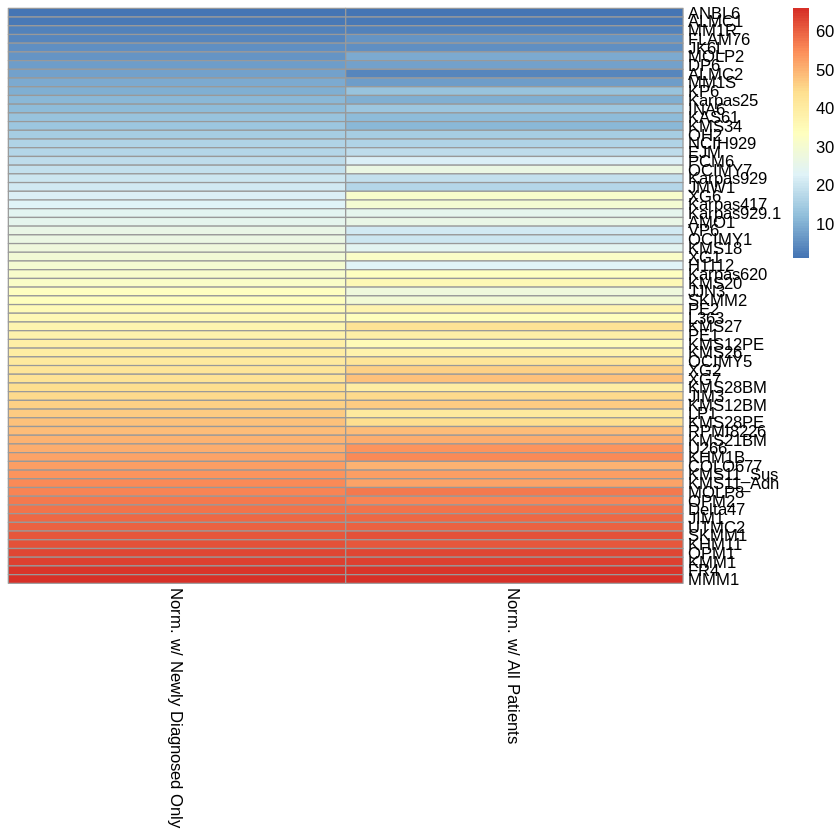

In [12]:
# creating vector of 1:number of cell lines for assigning rank

rank_gen = c(1:length(MM.cor.keats_ndo_5000_means[,1]))

# sorting patient correlate data frames to assign ranks

MM.cor.keats_ndo_5000_ranks = MM.cor.keats_ndo_5000_means[order(-MM.cor.keats_ndo_5000_means$cor),]
MM.cor.keats_ndo_5000_ranks$rank = rank_gen

MM.cor.keats_nd_5000_ranks = MM.cor.keats_nd_5000_means[order(-MM.cor.keats_nd_5000_means$cor),]
MM.cor.keats_nd_5000_ranks$rank = rank_gen

# checking output head

head(MM.cor.keats_ndo_5000_ranks)
head(MM.cor.keats_nd_5000_ranks)

# sorting by name to fuse data frames

MM.cor.keats_ndo_5000_ranks = MM.cor.keats_ndo_5000_ranks[order(rownames(MM.cor.keats_ndo_5000_ranks)),]
MM.cor.keats_nd_5000_ranks = MM.cor.keats_nd_5000_ranks[order(rownames(MM.cor.keats_nd_5000_ranks)),]

# checking output head

head(MM.cor.keats_ndo_5000_ranks)
head(MM.cor.keats_nd_5000_ranks)

# fusing data frames together by column for heatmap

rank_base_bound = cbind(MM.cor.keats_nd_5000_ranks, MM.cor.keats_ndo_5000_ranks)

# checking output head

head(rank_base_bound)

# pruning unnecessary columns and renaming columns

rank_base_bound = rank_base_bound[-1]
rank_base_bound = rank_base_bound[-1]
rank_base_bound = rank_base_bound[-2]
rank_base_bound = rank_base_bound[-2]
colnames(rank_base_bound) = c('Norm. w/ Newly Diagnosed Only', 'Norm. w/ All Patients')

# sorting by rank of newly diagnosed patients

rank_base_bound = rank_base_bound[order(rank_base_bound[,1]),]

# checking output head

head(rank_base_bound)

# getting heatmap

pheatmap(rank_base_bound, cluster_rows = FALSE, cluster_cols = FALSE)

,cor,NA,rank
,<dbl>,<chr>,<int>
ANBL6,0.7290833,nd,1
ALMC1,0.7092359,nd,2
MM1R,0.7090974,nd,3
MOLP2,0.7083627,nd,4
FLAM76,0.7081904,nd,5
DP6,0.7079986,nd,6


,cor,NA,rank
,<dbl>,<chr>,<int>
ANBL6,0.7163193,ndo,1
ALMC1,0.6973418,ndo,2
MM1R,0.6941688,ndo,3
ALMC2,0.6928485,ndo,4
FLAM76,0.6909355,ndo,5
DP6,0.6892044,ndo,6


,cor,NA,rank
,<dbl>,<chr>,<int>
ALMC1,0.6973418,ndo,2
ALMC2,0.6928485,ndo,4
AMO1,0.6586324,ndo,32
ANBL6,0.7163193,ndo,1
COLO677,0.6363937,ndo,53
Delta47,0.6265948,ndo,58


,cor,NA,rank
,<dbl>,<chr>,<int>
ALMC1,0.7092359,nd,2
ALMC2,0.7059912,nd,7
AMO1,0.6759982,nd,31
ANBL6,0.7290833,nd,1
COLO677,0.6519866,nd,54
Delta47,0.6438217,nd,58


,k5,k10
,<int>,<int>
ANBL6,1,1
ALMC1,2,2
MM1R,3,3
ALMC2,4,8
JK6L,5,5
FLAM76,6,4


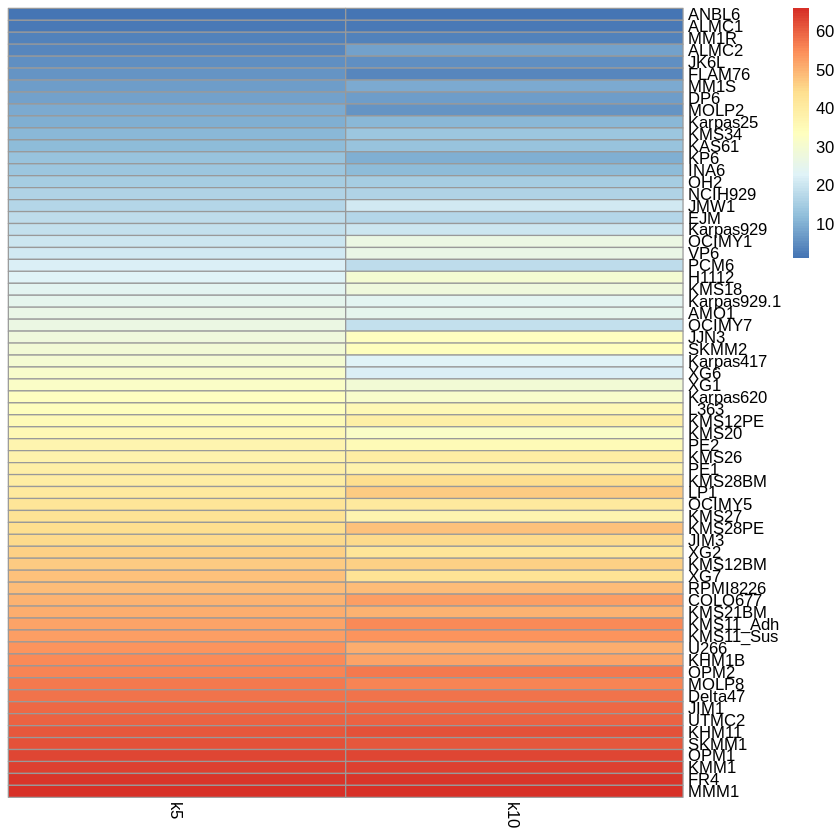

In [13]:
MM.cor.keats_nd_10000_means = data.frame(colMeans(MM.cor.keats_nd_10000))
MM.cor.keats_nd_10000_means$type = 'nd'
MM.cor.keats_ndo_10000_means = data.frame(colMeans(MM.cor.keats_ndo_10000))
MM.cor.keats_ndo_10000_means$type = 'ndo'

MM.cor.keats_nd_10000_ranks = (MM.cor.keats_nd_10000_means[order(-MM.cor.keats_nd_10000_means[,1]),])
colnames(MM.cor.keats_nd_10000_ranks) = c('cor')
MM.cor.keats_nd_10000_ranks$rank = rank_gen

MM.cor.keats_ndo_10000_ranks = (MM.cor.keats_ndo_10000_means[order(-MM.cor.keats_ndo_10000_means[,1]),])
colnames(MM.cor.keats_ndo_10000_ranks) = c('cor')
MM.cor.keats_ndo_10000_ranks$rank = rank_gen

head(MM.cor.keats_nd_10000_ranks)
head(MM.cor.keats_ndo_10000_ranks)

MM.cor.keats_ndo_10000_ranks = MM.cor.keats_ndo_10000_ranks[order(rownames(MM.cor.keats_ndo_10000_ranks)),]
MM.cor.keats_nd_10000_ranks = MM.cor.keats_nd_10000_ranks[order(rownames(MM.cor.keats_nd_10000_ranks)),]

head(MM.cor.keats_ndo_10000_ranks)
head(MM.cor.keats_nd_10000_ranks)

fiveten_ndo_bound = cbind(MM.cor.keats_ndo_5000_ranks, MM.cor.keats_nd_5000_ranks)
fiveten_ndo_bound = fiveten_ndo_bound[-1]
fiveten_ndo_bound = fiveten_ndo_bound[-1]
fiveten_ndo_bound = fiveten_ndo_bound[-2]
fiveten_ndo_bound = fiveten_ndo_bound[-2]
colnames(fiveten_ndo_bound) = c('k5','k10')
fiveten_ndo_bound = fiveten_ndo_bound[order(fiveten_ndo_bound$k5),]

head(fiveten_ndo_bound)

pheatmap(fiveten_ndo_bound, cluster_rows = FALSE, cluster_cols = FALSE)

[1] 16172

[1] 81

[1] 779

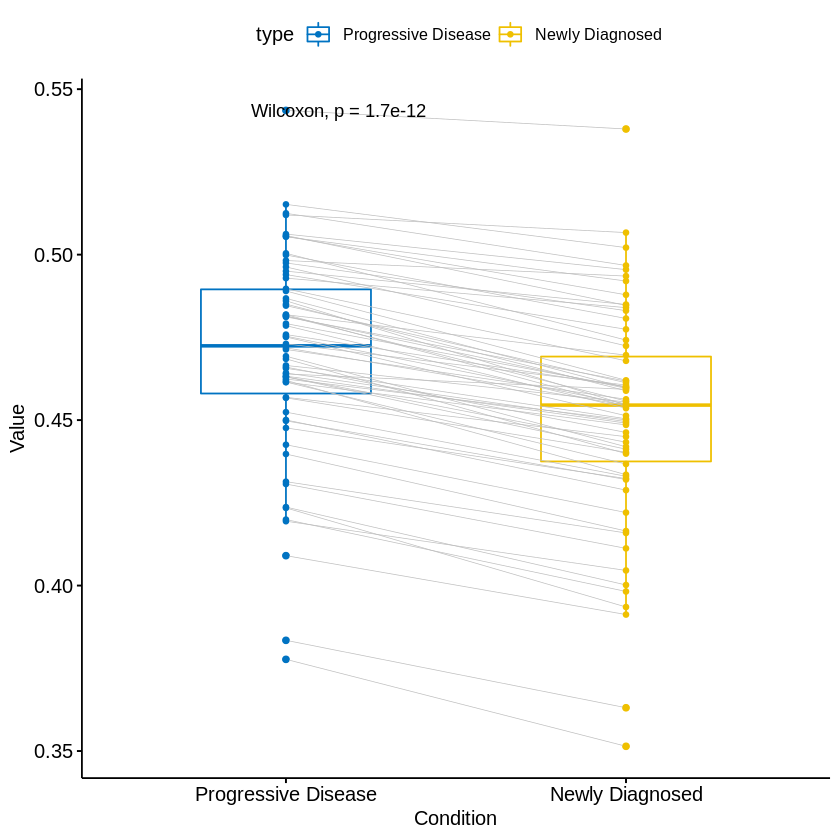

In [14]:
MM_pat_ppv = data.frame(fread("MMRF_CoMMpass_IA13_PER_PATIENT_VISIT.csv"))

length(MM_pat_ppv[,1])

MM_pat_ppv_bool = MM_pat_ppv$AT_TREATMENTRESP %in% c('Progressive Disease')
MM_pat_pd = MM_pat_ppv[MM_pat_ppv_bool,]
MM_pat_pd_id = unique(MM_pat_pd$SPECTRUM_SEQ)
MM_pat_pd_id = MM_pat_pd_id[-1]
MM_pat_pd_id = paste(MM_pat_pd_id, '_BM', sep = '')
# MM_patients_2 = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))
# rownames(MM_patients_2) = MM_patients_2$GENE_ID
# MM_patients_2 = MM_patients_2[-1]
# length(MM_cell_line[,1])
# MM_pat_test = rownames(MM_patients_2) %in% rownames(MM_cell_line)
# MM_patients_2 = MM_patients_2[MM_pat_test,]
# MM_pat_bool_2 = (colnames(MM_patients_2) %in% MM_pat_pd_id)
# MM_patients_2 = MM_patients_2[,MM_pat_bool_2]
# head(MM_patients_2)
# MM_combined_2 = cbind(MM_cell_line, MM_patients_2)
# norm_combined_pd = vst(as.matrix(MM_combined_2))
# head(norm_combined_pd)


# norm_combined_pd_5 = norm_combined_pd[keepi5000,]
# makeplots(norm_combined_pd_5, colnames(MM_patients_2), colnames(MM_cell_line), '')


# MM.cor.pd = cor(norm_combined_pd_5, method = 's')

MM.pd.bool = rownames(MM.cor.keats_5000) %in% MM_pat_pd_id
sum(MM.pd.bool)

MM.pd.bool.neg = rownames(MM.cor.keats_5000) %in% rownames(MM.cor.keats_nd_5000)
sum(MM.pd.bool.neg)

MM.cor.pd = MM.cor.keats_5000[MM.pd.bool,]
MM.cor.nd = MM.cor.keats_5000[MM.pd.bool.neg,]

MM.cor.pd.m = data.frame(colMeans(MM.cor.pd))
MM.cor.pd.m$type = 'Progressive Disease'
colnames(MM.cor.pd.m) = c('cor', 'type')

MM.cor.nd.m = data.frame(colMeans(MM.cor.nd))
MM.cor.nd.m$type = 'Newly Diagnosed'
colnames(MM.cor.nd.m) = c('cor', 'type')

pd_bound = rbind(MM.cor.pd.m, MM.cor.nd.m)

 ggpaired(pd_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.2,
         palette = "jco")+
  stat_compare_means(paired = TRUE)
# MM.cor.pd = MM.cor.pd[,colnames(MM_cell_line)]
# MM.cor.pd = MM.cor.pd[colnames(MM_patients_2),]

# MM.cor.pd_m = data.frame(colMeans(MM.cor.pd))
# MM.cor.pd_m$type = 'Progressive Disease'
# colnames(MM.cor.pd_m) = c('cor', 'type')

# MM.cor.keats_ma = data.frame(colMeans(MM.cor.keats_5000))
# MM.cor.keats_ma$type = 'Newly Diagnosed'
# colnames(MM.cor.keats_ma) = c('cor', 'type')

# head(MM.cor.pd_m)
# head(MM.cor.keats_ma)

# pd_bound = rbind(MM.cor.pd_m, MM.cor.keats_ma)

#  ggpaired(pd_bound, x = "type", y = "cor",
#          color = "type", line.color = "gray", line.size = 0.2,
#          palette = "jco")+
#   stat_compare_means(paired = TRUE)

,cor,type
,<dbl>,<chr>
ALMC1,0.5008383,Progressive Disease
ALMC2,0.4957164,Progressive Disease
AMO1,0.4549656,Progressive Disease
ANBL6,0.5321433,Progressive Disease
COLO677,0.4395266,Progressive Disease
Delta47,0.4058490,Progressive Disease


,cor,type
,<dbl>,<chr>
ALMC1,0.5045872,Newly Diagnosed
ALMC2,0.4893301,Newly Diagnosed
AMO1,0.4388228,Newly Diagnosed
ANBL6,0.5358342,Newly Diagnosed
COLO677,0.4218150,Newly Diagnosed
Delta47,0.3967160,Newly Diagnosed


,cor,type
,<dbl>,<chr>
ALMC1,0.5045872,Newly Diagnosed
ALMC2,0.4893301,Newly Diagnosed
AMO1,0.4388228,Newly Diagnosed
ANBL6,0.5358342,Newly Diagnosed
COLO677,0.4218150,Newly Diagnosed
Delta47,0.3967160,Newly Diagnosed


,cor,type
,<dbl>,<chr>
UTMC21,0.3993215,Progressive Disease
VP61,0.4564247,Progressive Disease
XG11,0.4460780,Progressive Disease
XG21,0.4352171,Progressive Disease
XG61,0.4354811,Progressive Disease
XG71,0.4263513,Progressive Disease


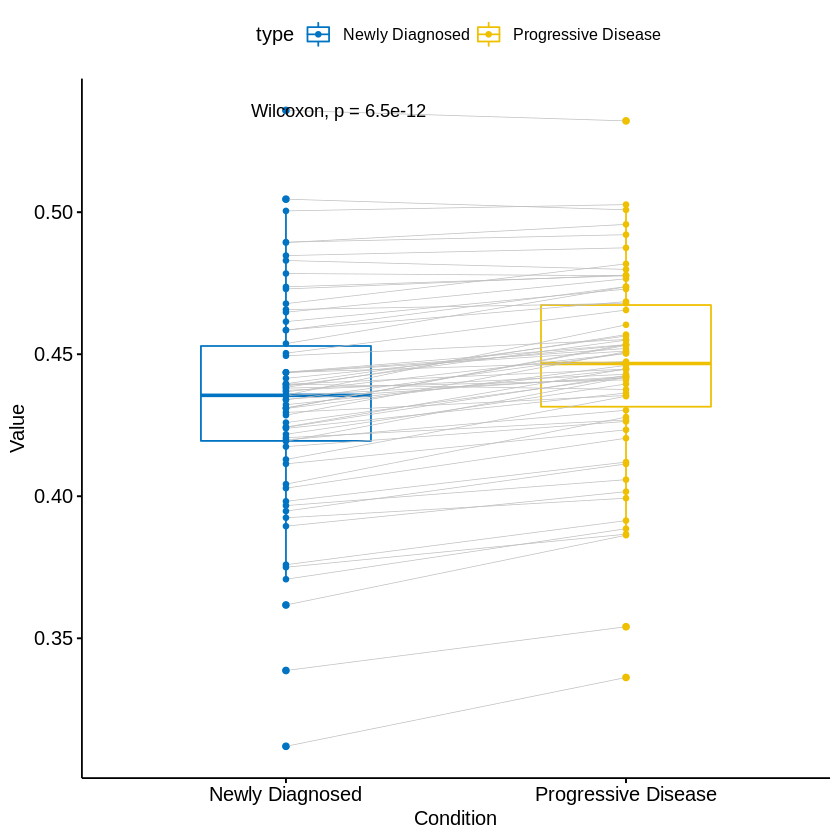

In [15]:
norm_pat_pd = norm_combined[,(colnames(norm_combined) %in% MM_pat_pd_id)]
# norm_combined_pd = cbind(norm_cell, norm_pat_pd)

keepi_pd = apply(norm_pat_pd, 1, IQR)
keepis_pd = sort(keepi_pd, decreasing = TRUE)
keepi5000_pd = keepi_pd %in% keepis_pd[1:5000]
keepi10000_pd = keepi_pd %in% keepis_pd[1:10000]

norm_combined_pd = norm_combined[keepi5000_pd,]

MM.cor.pd.n = norm_combined[keepi5000_pd,]
MM.cor.pd.n = cor(MM.cor.pd.n, method = 's')
MM.cor.pd.n = MM.cor.pd.n[,colnames(MM_cell_line)]
MM.cor.pd.n1 = MM.cor.pd.n[rownames(MM.cor.pd.n) %in% MM_pat_pd_id,]
MM.cor.pd.n1 = data.frame(colMeans(MM.cor.pd.n1))
MM.cor.pd.n1$type = 'Progressive Disease'
colnames(MM.cor.pd.n1) = c('cor', 'type')

# MM.cor.pd.m2 = data.frame(colMeans(MM.cor.pd.n2))


MM.cor.pd.n2 = MM.cor.pd.n[rownames(MM.cor.pd.n) %in% colnames(MM_patients_nd),]
MM.cor.pd.n2 = data.frame(colMeans(MM.cor.pd.n2))
MM.cor.pd.n2$type = 'Newly Diagnosed'
colnames(MM.cor.pd.n2) = c('cor', 'type')


head(MM.cor.pd.n1)
head(MM.cor.pd.n2)

pd_bound2 = rbind(MM.cor.pd.n2, MM.cor.pd.n1)

head(pd_bound2)
tail(pd_bound2)

 ggpaired(pd_bound2, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.2,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [16]:
sum(rownames(norm_combined_pd) %in% rownames(norm_combined_5))

[1] 4308